# Anomaly Detection in Network Data using GPU-Accelerated Deep Learning (AutoEncoder)
* Duckhwan Kim


In this session, we will build a simple deep learning models for anomaly detection in network intrusion with KDD99 dataset. It is composed of 1) data pre-processing, 2) model training, and 3) validation. 

For more information about the dataset, please visit https://kdd.ics.uci.edu/databases/kddcup99/task.html.


# Google Colab Setting
For deep learning, we will use PyTorch (https://pytorch.org/), well known deep learning framework. In this session, we will not cover PyTorch or Deep Learning in detail.

We can easily import PyTorch in Python in Google Colab environment and run it with Nvidia GPU or Google TPU for free !!!!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

1.3.0+cu100


Let's check GPU, CPU, RAM, and HDD for this lab

In [2]:
# Check all environments


!nvidia-smi
!lscpu |grep 'Model name'
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'
#hard disk that we can use
!df -h / | awk '{print $4}'

Tue Oct 29 05:23:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# from google.colab import drive

# drive.mount('/content/gdrive')

# KDD99 Dataset Download
Load data from the website in gz format. You just need to run this cell once.

In [4]:
import os
import os.path
import gzip
from os import path
if path.exists("kddcup.data.gz") and path.exists("kddcup.data.corrected"):
  print("file already exists")
else:
  print("Download file")
  !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
  input = gzip.GzipFile("./kddcup.data.gz",'rb')
  s = input.read()
  input.close()
  output = open("./kddcup.data.corrected", 'wb')
  output.write(s)
  output.close()

  print("done")



data_path = "./kddcup.data.corrected"

Download file
--2019-10-29 05:23:16--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz’

kddcup.data.gz      100%[===================>]  17.28M  18.6MB/s    in 0.9s    

2019-10-29 05:23:18 (18.6 MB/s) - ‘kddcup.data.gz’ saved [18115902/18115902]

done


KDD99 dataset **kddcup.data.corrected** is csv format and it has 41 columns: 34 numeric columns and 7 categorical columns. Our goal is detecting anomalies from thie *Network Packet logs*

In [5]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

print("Total number of columns : {}".format(len(col_names)-1))
# last column is label

import pandas as pd
df =  pd.read_csv(data_path, header=None, names=col_names, index_col=False)

print("dataFrame shape")
print(df.shape)


Total number of columns : 41
dataFrame shape
(4898431, 42)


Let's look at the first 5 rows.

In [6]:
pd.set_option('display.max_columns', None)
print(df.head())

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        215      45076     0   
1         0           tcp    http   SF        162       4528     0   
2         0           tcp    http   SF        236       1228     0   
3         0           tcp    http   SF        233       2032     0   
4         0           tcp    http   SF        239        486     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          1                0   
1               0       0    0                  0          1                0   
2               0       0    0                  0          1                0   
3               0       0    0                  0          1                0   
4               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0      

# One-Hot Encoding
Each row of the KDD99 is a network connection and it has **41** variables (features) and **1** label (normal or anormal). 

**41** features are 


1.   basic input features of network connections ex: duration, protocol type, and number of bytes from source IP
2.   Content input features of network connections
3.   The statistical input features during the time window.

For detail, please visit https://kdd.ics.uci.edu/databases/kddcup99/task.html.




In [0]:
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

print("In protocol_type (categorical)...")
print(df['protocol_type'].unique())

print("In service (categorical)...")
print(df['service'].unique())




In protocol_type (categorical)...
['tcp' 'udp' 'icmp']
In service (categorical)...
['http' 'smtp' 'domain_u' 'auth' 'finger' 'telnet' 'eco_i' 'ftp' 'ntp_u'
 'ecr_i' 'other' 'urp_i' 'private' 'pop_3' 'ftp_data' 'netstat' 'daytime'
 'ssh' 'echo' 'time' 'name' 'whois' 'domain' 'mtp' 'gopher' 'remote_job'
 'rje' 'ctf' 'supdup' 'link' 'systat' 'discard' 'X11' 'shell' 'login'
 'imap4' 'nntp' 'uucp' 'pm_dump' 'IRC' 'Z39_50' 'netbios_dgm' 'ldap'
 'sunrpc' 'courier' 'exec' 'bgp' 'csnet_ns' 'http_443' 'klogin' 'printer'
 'netbios_ssn' 'pop_2' 'nnsp' 'efs' 'hostnames' 'uucp_path' 'sql_net'
 'vmnet' 'iso_tsap' 'netbios_ns' 'kshell' 'urh_i' 'http_2784' 'harvest'
 'aol' 'tftp_u' 'http_8001' 'tim_i' 'red_i']


We want to [one-hot encode](https://en.wikipedia.org/wiki/One-hot) categorical features. ex: protocol_type = [tcp, udp, icmp] = [001, 010, 100]

In [9]:
cat_data = pd.get_dummies(df[cat_vars])

print(cat_data.shape)

(4898431, 88)


In [10]:
df[cat_vars].head()

,protocol_type,service,flag,land,logged_in,is_host_login,is_guest_login
0,tcp,http,SF,0,1,0,0
1,tcp,http,SF,0,1,0,0
2,tcp,http,SF,0,1,0,0
3,tcp,http,SF,0,1,0,0
4,tcp,http,SF,0,1,0,0


In [11]:
cat_data.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [12]:
numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()
# check that the numeric data has been captured accurately
print(numeric_data.shape)


(4898431, 34)


In [13]:
numeric_data.head()

,diff_srv_rate,dst_host_srv_diff_host_rate,num_failed_logins,serror_rate,dst_host_same_src_port_rate,num_outbound_cmds,dst_host_serror_rate,srv_serror_rate,dst_host_srv_serror_rate,wrong_fragment,srv_diff_host_rate,src_bytes,dst_bytes,num_compromised,count,dst_host_srv_rerror_rate,hot,duration,num_access_files,srv_count,srv_rerror_rate,num_file_creations,dst_host_rerror_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,rerror_rate,root_shell,su_attempted,same_srv_rate,dst_host_diff_srv_rate,urgent,num_shells,num_root
0,0.0,0.0,0,0.0,0.00,0,0.0,0.0,0.0,0,0.0,215,45076,0,1,0.0,0,0,0,1,0.0,0,0.0,0,0,0.0,0.0,0,0,1.0,0.0,0,0,0
1,0.0,0.0,0,0.0,1.00,0,0.0,0.0,0.0,0,0.0,162,4528,0,2,0.0,0,0,0,2,0.0,0,0.0,1,1,1.0,0.0,0,0,1.0,0.0,0,0,0
2,0.0,0.0,0,0.0,0.50,0,0.0,0.0,0.0,0,0.0,236,1228,0,1,0.0,0,0,0,1,0.0,0,0.0,2,2,1.0,0.0,0,0,1.0,0.0,0,0,0
3,0.0,0.0,0,0.0,0.33,0,0.0,0.0,0.0,0,0.0,233,2032,0,2,0.0,0,0,0,2,0.0,0,0.0,3,3,1.0,0.0,0,0,1.0,0.0,0,0,0
4,0.0,0.0,0,0.0,0.25,0,0.0,0.0,0.0,0,0.0,239,486,0,3,0.0,0,0,0,3,0.0,0,0.0,4,4,1.0,0.0,0,0,1.0,0.0,0,0,0


In [14]:
# concat numeric and the encoded categorical variables
label_data = df['label']
encode_data = pd.concat([numeric_data, cat_data, label_data], axis=1)
encode_data.head()

,diff_srv_rate,dst_host_srv_diff_host_rate,num_failed_logins,serror_rate,dst_host_same_src_port_rate,num_outbound_cmds,dst_host_serror_rate,srv_serror_rate,dst_host_srv_serror_rate,wrong_fragment,srv_diff_host_rate,src_bytes,dst_bytes,num_compromised,count,dst_host_srv_rerror_rate,hot,duration,num_access_files,srv_count,srv_rerror_rate,num_file_creations,dst_host_rerror_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,rerror_rate,root_shell,su_attempted,same_srv_rate,dst_host_diff_srv_rate,urgent,num_shells,num_root,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,label
0,0.0,0.0,0,0.0,0.00,0,0.0,0.0,0.0,0,0.0,215,45076,0,1,0.0,0,0,0,1,0.0,0,0.0,0,0,0.0,0.0,0,0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,normal.
1,0.0,0.0,0,0.0,1.00,0,0.0,0.0,0.0,0,0.0,162,4528,0,2,0.0,0,0,0,2,0.0,0,0.0,1,1,1.0,0.0,0,0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,normal.
2,0.0,0.0,0,0.0,0.50,0,0.0,0.0,0.0,0,0.0,236,1228,0,1,0.0,0,0,0,1,0.0,0,0.0,2,2,1.0,0.0,0,0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,normal.
3,0.0,0.0,0,0.0,0.33,0,0.0,0.0,0.0,0,0.0,233,2032,0,2,0.0,0,0,0,2,0.0,0,0.0,3,3,1.0,0.0,0,0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,normal.
4,0.0,0.0,0,0.0,0.25,0,0.0,0.0,0.0,0,0.0,239,486,0,3,0.0,0,0,0,3,0.0,0,0.0,4,4,1.0,0.0,0,0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,normal.


# Adjusting normal ratio
Before we start, let's look at our dataset and calculate the ratio of **normal data**

In [15]:
labels = df['label'].copy()
num_data = len(labels)
num_normal = np.sum(labels =='normal.')
normal_ratio = num_normal/num_data
print('normal_ratio(%)', normal_ratio*100)

normal_ratio(%) 19.859032412623552


In real scenario, most of data are normal and anomal ratio is very small. Let's reduce the dataset to make anomal ratio small (~0.1%)

In [16]:
anomal_ratio = 0.001
def reduce_data(df, anomal_ratio):
    num_anomalies = int(num_normal * (anomal_ratio /(1-anomal_ratio)))
    print('number of anomalies = ', num_anomalies, 'number of normal = ', num_normal)
    anomal_labels = labels[labels !='normal.']
    anomal_idx = np.random.choice(anomal_labels.index, size = num_anomalies, replace = False)
    anomal_data = df.iloc[anomal_idx].copy()
    normal_data = df[labels =='normal.'].copy()
    print('anomal_data shape = ', anomal_data.shape)
    print('normal_data shape = ',normal_data.shape)
    return pd.concat([normal_data, anomal_data], axis = 0)

encode_data_reduce = reduce_data(encode_data, anomal_ratio)
print('reduced_data shape = ',encode_data_reduce.shape)

number of anomalies =  973 number of normal =  972781
anomal_data shape =  (973, 123)
normal_data shape =  (972781, 123)
reduced_data shape =  (973754, 123)


# Label encoding
In KDD99 dataset, there are 22 attack types (https://kdd.ics.uci.edu/databases/kddcup99/training_attack_types). Therefore, total number of labe types are **23** (22 + 1 (normal)). Let's look at labels and convert them into the integer between 0 ~ 22

Let's load **sklearn**(scikit-learn), which is package for machine learning in Python (https://scikit-learn.org/stable/). It provides efficient tools for data mining and data analysis. We need this package for pre-processing and quantify the anomaly detection quality later.



*   [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)  
*   [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)



In [17]:
le = LabelEncoder()
le.fit(encode_data_reduce.label)
print(le.classes_)

# capture the labels
labels = encode_data_reduce['label'].copy()


# convert labels to integers
integer_labels = le.transform(labels)

# what is normal idx
normal_idx = le.transform(['normal.'])
print("normal. is encoded to = {}".format(normal_idx))

['ipsweep.' 'neptune.' 'normal.' 'portsweep.' 'satan.' 'smurf.'
 'warezclient.']
normal. is encoded to = [2]


# Let's exclude label from dataset (Unsupervised learning)
After pre-processing, now we have about 980k data (1% anomalies). In this dataset, we have the label for each data. In real scenario, however, labeling the training set is huge work and it is impractical. Therefore, we will assume that we don't have the label in our dataset.

In [18]:
feature_lists = list(set(encode_data_reduce.columns.values.tolist()))
feature_lists.remove('label')
encode_data_reduce_without_label = encode_data_reduce[feature_lists].copy()
print(encode_data_reduce.shape)
print(encode_data_reduce_without_label.shape)

input_size = encode_data_reduce_without_label.shape[1]

encode_data_reduce_without_label.head()

(973754, 123)
(973754, 122)


,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,wrong_fragment,service_mtp,service_auth,service_domain_u,num_compromised,flag_S0,count,service_exec,service_sql_net,service_uucp_path,service_telnet,service_link,service_echo,service_other,protocol_type_tcp,service_sunrpc,flag_RSTO,service_printer,rerror_rate,service_hostnames,flag_SH,service_urh_i,service_tftp_u,same_srv_rate,dst_host_diff_srv_rate,service_netstat,service_urp_i,service_netbios_ssn,flag_RSTOS0,protocol_type_icmp,service_courier,land,service_remote_job,srv_serror_rate,src_bytes,service_X11,dst_bytes,service_whois,hot,service_Z39_50,protocol_type_udp,service_bgp,service_supdup,num_access_files,service_ecr_i,service_ftp,logged_in,srv_rerror_rate,num_file_creations,service_ntp_u,root_shell,service_IRC,service_http_443,service_pop_3,service_netbios_dgm,urgent,is_guest_login,service_smtp,service_discard,service_http_2784,serror_rate,num_failed_logins,service_netbios_ns,dst_host_same_src_port_rate,num_outbound_cmds,flag_REJ,service_iso_tsap,service_ldap,flag_OTH,dst_host_srv_rerror_rate,service_imap4,service_rje,duration,flag_RSTR,srv_count,flag_S2,service_daytime,dst_host_rerror_rate,service_shell,service_time,dst_host_count,dst_host_same_srv_rate,service_systat,service_vmnet,flag_SF,num_shells,service_gopher,num_root,service_aol,service_login,service_csnet_ns,service_klogin,service_http_8001,diff_srv_rate,service_nnsp,flag_S3,service_domain,service_http,service_ssh,is_host_login,service_ctf,service_name,srv_diff_host_rate,service_ftp_data,service_pop_2,service_efs,service_harvest,service_private,service_tim_i,service_finger,service_pm_dump,service_eco_i,service_uucp,dst_host_srv_count,flag_S1,service_kshell,su_attempted,service_nntp,service_red_i
0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1.0,0.0,0,0,0,0,0,0,0,0,0.0,215,0,45076,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.00,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0.0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1.0,0.0,0,0,0,0,0,0,0,0,0.0,162,0,4528,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1.00,0,0,0,0,0,0.0,0,0,0,0,2,0,0,0.0,0,0,1,1.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1.0,0.0,0,0,0,0,0,0,0,0,0.0,236,0,1228,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.50,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0.0,0,0,2,1.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
3,0.0,0.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1.0,0.0,0,0,0,0,0,0,0,0,0.0,233,0,2032,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.33,0,0,0,0,0,0.0,0,0,0,0,2,0,0,0.0,0,0,3,1.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0
4,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1.0,0.0,0,0,0,0,0,0,0,0,0.0,239,0,486,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.25,0,0,0,0,0,0.0,0,0,0,0,3,0,0,0.0,0,0,4,1.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0


# MinMaxScale

In [19]:
from sklearn import preprocessing
A=[[1,2,3,4],[10,-2,9,7],[3,4,9,1]]


min_max_scaler = preprocessing.MinMaxScaler()
A_scaled = min_max_scaler.fit_transform(A)
encode_data_reduce_without_label_scaled = min_max_scaler.fit_transform(encode_data_reduce_without_label)

encode_data_reduce_without_label_scaled = pd.DataFrame(encode_data_reduce_without_label_scaled)
encode_data_reduce_without_label_scaled.head()
# for columnName, columnData in encode_data_reduce.iteritems():
#     x = columnData.values
#     x_scaled = min_max_scaler.fit_transform(x)
#     encode_data_reduce = x_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.003843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.000386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.0,0.0,0.0,0.0,0.0,0.003922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.0,0.000105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.0,0.0,0.0,0.0,0.0,0.007843,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007843,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.0,0.000173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.0,0.0,0.0,0.0,0.0,0.011765,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011765,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.0,0.000041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005871,0.0,0.0,0.0,0.0,0.0,0.015686,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015686,0.0,0.0,0.0,0.0,0.0


# Preparing Training and Testing Dataset

Now we finished data pre-processing. We need to split the data into **training dataset** and **test dataset**. We will set 80% of total data as **training dataset**. You can choose any ratio you want. But here is the [guideline](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). *train_test_split()* is the function from **sklearn** and it split the data with the ratio and *shuffle* the data (that's why we want to put random seed as *random_state*)

In [20]:
# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(encode_data_reduce_without_label_scaled,
                                                    integer_labels,
                                                    test_size=0.8, 
                                                    random_state=1029)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(194750, 122)
(194750,)
(779004, 122)
(779004,)


# AutoEncoder
In this lab, we will use AutoEncoder to detect anomaly. Before starting let's look at AutoEncoder with MNIST shortly ('Simple AutoEncoder.ipynb')

[Link](https://colab.research.google.com/drive/19-KwYY2-Gvj1uzcvgUvvxQ4I-LVV8o9d)

# AutoEncoder for KDD99
Now let's build similar AutoEncoder for KDD99

In [0]:
import torch
from torch.autograd import Variable
from torch import nn

class autoencoder(nn.Module):
  def __init__(self, input_size):
    super(autoencoder,self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 96),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(96,64),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(64,48),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(48,16),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(16,4),
    )
    self.decoder = nn.Sequential(
        nn.Linear(4,16),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(16, 48),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(48, 64),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(64, 96),
        nn.Tanh(),
        nn.Dropout(0.1),
        
        nn.Linear(96, input_size))
    
  def forward(self, x):
    h = self.encoder(x)
    o = self.decoder(h)
    return o

In [0]:
from torch.utils.data import Dataset, DataLoader
training_generator = DataLoader(x_train, batch_size=128, shuffle=True)

In [0]:
class KDD99_Dataset(Dataset):
  """KDD99 Dataset for PyTorch"""
  def __init__(self, df):
    tmp = df.values
    self.data_torch = torch.from_numpy(tmp).type(torch.FloatTensor)
    
  def __len__(self):
    return self.data_torch.shape[0]
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.data_torch[idx,:]

In [0]:
batch_size = 512
x_train_dataset = KDD99_Dataset(x_train)
x_test_dataset = KDD99_Dataset(x_test)
train_dataloader = DataLoader(x_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
test_dataloader = DataLoader(x_test_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)

In [0]:
model = autoencoder(input_size)
model = model.cuda()
criterion = torch.nn.MSELoss()
learning_rate = .0003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [26]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched.shape)
    break

0 torch.Size([512, 122])


In [27]:
save_model_path = 'ae_kdd99_model'
FULL_TRAIN = True
num_epochs = 10
if (FULL_TRAIN):
    for epoch in range(num_epochs):
        running_training_loss =0.0
        running_test_loss = 0.0

        for i_batch, sample_batched in enumerate(train_dataloader):
            sample_batched = sample_batched.cuda()
            sample_batched = Variable(sample_batched)
            output = model(sample_batched)
            train_loss = criterion(output, sample_batched)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            running_training_loss += train_loss.item()

        if (epoch%10 ==9):
            for i_batch, sample_batched in enumerate(test_dataloader):
                sample_batched = sample_batched.cuda()
                sample_batched = Variable(sample_batched)
                test_output = model(sample_batched)
                test_loss = criterion(test_output, sample_batched)
                running_test_loss += test_loss.item()
            print(">>>> @ {}, test_loss = {}".format(epoch+1, running_test_loss/len(test_dataloader)))


        print("@ {}, train_loss = {}".format(epoch+1, running_training_loss/len(train_dataloader)))
        torch.save(model.state_dict(), save_model_path)
else:
    print("Load previous trained model")
    model.load_state_dict(torch.load(save_model_path))
    

@ 1, train_loss = 0.016738590625483846
@ 2, train_loss = 0.007599144781697688
@ 3, train_loss = 0.005964258793262359
@ 4, train_loss = 0.00494934983791055
@ 5, train_loss = 0.0042293046447118435
@ 6, train_loss = 0.0037271496418159545
@ 7, train_loss = 0.003407389811653243
@ 8, train_loss = 0.003153507744409437
@ 9, train_loss = 0.002940001098800871
>>>> @ 10, test_loss = 0.0027069516518825124
@ 10, train_loss = 0.002768635944147983


In [28]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
encoder.0.weight 	 torch.Size([96, 122])
encoder.0.bias 	 torch.Size([96])
encoder.3.weight 	 torch.Size([64, 96])
encoder.3.bias 	 torch.Size([64])
encoder.6.weight 	 torch.Size([48, 64])
encoder.6.bias 	 torch.Size([48])
encoder.9.weight 	 torch.Size([16, 48])
encoder.9.bias 	 torch.Size([16])
encoder.12.weight 	 torch.Size([4, 16])
encoder.12.bias 	 torch.Size([4])
decoder.0.weight 	 torch.Size([16, 4])
decoder.0.bias 	 torch.Size([16])
decoder.3.weight 	 torch.Size([48, 16])
decoder.3.bias 	 torch.Size([48])
decoder.6.weight 	 torch.Size([64, 48])
decoder.6.bias 	 torch.Size([64])
decoder.9.weight 	 torch.Size([96, 64])
decoder.9.bias 	 torch.Size([96])
decoder.12.weight 	 torch.Size([122, 96])
decoder.12.bias 	 torch.Size([122])


## Compute threshold and reconstruction errors


In [29]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve

print(type(x_test))
x_test_array = x_test.values
print(type(x_test_array))
x_test_torch = torch.from_numpy(x_test_array).type(torch.FloatTensor)
x_test_variable = Variable(x_test_torch).cuda()
x_test_recon = model(x_test_variable)
print(type(x_test_recon))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [0]:
scores = np.mean((x_test_array - x_test_recon.detach().cpu().numpy())**2, axis=1)

In [0]:
def convert_label_to_binary(labels, normal_idx):
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

In [0]:
bin_y_test = convert_label_to_binary(y_test, normal_idx)

In [0]:
anomaly_data = pd.DataFrame({'recon_score':scores})

In [0]:
anomaly_data['binary_labels'] = bin_y_test

In [35]:
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                778245.0  0.002665  0.004103  0.000038  0.000562  0.001118   
1                   759.0  0.047051  0.023018  0.025275  0.032535  0.034664   

                                   
                    75%       max  
binary_labels                      
0              0.002819  0.097974  
1              0.052713  0.100172

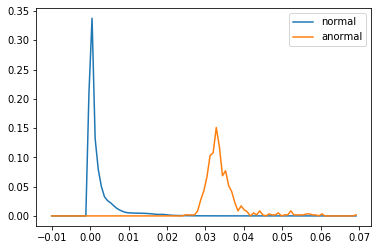

In [36]:
normal_data = anomaly_data[anomaly_data['binary_labels']==0]
anormal_data = anomaly_data[anomaly_data['binary_labels']==1]
normal_data_score = normal_data['recon_score'].to_numpy()
anormal_data_score = anormal_data['recon_score'].to_numpy()
bins = np.linspace(-0.01, 0.07, num = 100)
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=bins)

n_n, n_bins = np.histogram(normal_data_score, bins = bins)
an_n, an_bins = np.histogram(anormal_data_score, bins = bins);

n_density = n_n/np.sum(n_n)
an_density = an_n/np.sum(an_n)
plt.plot(bins[0:99], n_density, label = 'normal')
plt.plot(bins[0:99], an_density, label = 'anormal')
plt.legend();
plt.show()


### Roc Curve 
From [wiki](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

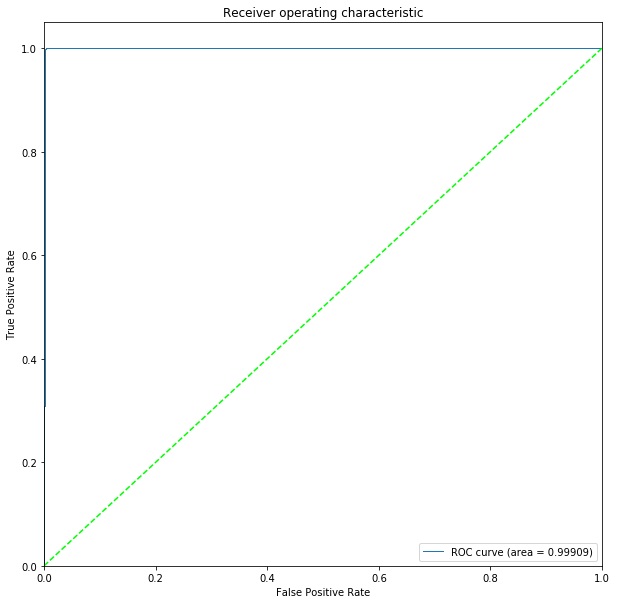

In [37]:
fpr, tpr, thresholds = roc_curve(bin_y_test, scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [38]:
optimal_threshold_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.02527546646435574


Confusion Matrix: 


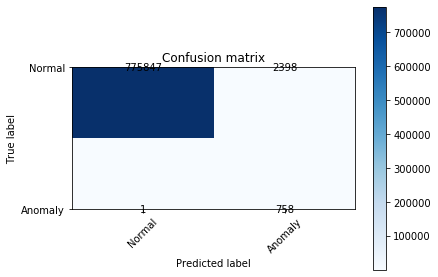

In [39]:
thresh = optimal_threshold
pred_labels = (scores > thresh).astype(int)

results = confusion_matrix(bin_y_test, pred_labels)
ae_acc = accuracy_score(bin_y_test, pred_labels)

print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

In [40]:
print("AutoEncoder accuracy = ", ae_acc)

AutoEncoder accuracy =  0.9969204265960123


## Debug